In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import nltk
from sklearn.preprocessing import LabelEncoder
import string
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split
nltk.download('punkt_tab')

In [2]:
df = pd.read_csv("spam.csv", encoding="latin1")

1.Data Cleaning
2.EDA
3.Text preprocessing
4. Model building
5. Evaulation
6. Improvement 
7. Website
8. Deploy

# 1. Data cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1, inplace=True)  # Dropping unwanted columns

In [5]:
df.rename(columns={'v1': "target", 'v2':"text"}, inplace=True)   # Renaming columns name

In [6]:
df.query("target=='spam'")  # getting only spam rows

,target,text
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."
...,...,...
5537,spam,Want explicit SEX in 30 secs? Ring 02073162414...
5540,spam,ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547,spam,Had your contract mobile 11 Mnths? Latest Moto...
5566,spam,REMINDER FROM O2: To get 2.50 pounds free call...


In [7]:
encoder = LabelEncoder()

In [8]:
df["target"] = encoder.fit_transform(df["target"])  # converting spam to 1 and ham to 0

In [9]:
df.isnull().sum()

target    0
text      0
dtype: int64

In [10]:
df.duplicated().sum()

np.int64(403)

In [11]:
df = df.drop_duplicates(keep='first')

In [12]:
df.duplicated().sum()

np.int64(0)

In [13]:
df.shape

(5169, 2)

In [14]:
df["target"].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

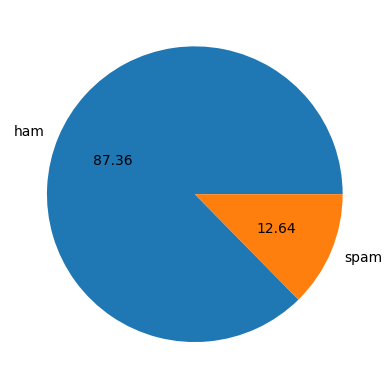

In [15]:
plt.pie([4515, 653], labels=["ham", "spam"], autopct="%0.2f")
plt.show()

#### Data is imbalanced

In [16]:
df["num_characters"] = df["text"].apply(len)

In [17]:
df["num_words"] = df["text"].apply(lambda x: len(nltk.word_tokenize(x)))

In [18]:
df["num_sentences"] = df["text"].apply(lambda x: len(nltk.sent_tokenize(x)))

In [19]:
df.describe()

,target,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000,5169.000000
mean,0.126330,78.977945,18.455794,1.965564
std,0.332253,58.236293,13.324758,1.448541
min,0.000000,2.000000,1.000000,1.000000
25%,0.000000,36.000000,9.000000,1.000000
50%,0.000000,60.000000,15.000000,1.000000
75%,0.000000,117.000000,26.000000,2.000000
max,1.000000,910.000000,220.000000,38.000000


In [20]:
df[df["target"] == 0].describe()  # Ham messages

,target,num_characters,num_words,num_sentences
count,4516.0,4516.000000,4516.000000,4516.000000
mean,0.0,70.459256,17.123782,1.820195
std,0.0,56.358207,13.493970,1.383657
min,0.0,2.000000,1.000000,1.000000
25%,0.0,34.000000,8.000000,1.000000
50%,0.0,52.000000,13.000000,1.000000
75%,0.0,90.000000,22.000000,2.000000
max,0.0,910.000000,220.000000,38.000000


In [21]:
df[df["target"] == 1].describe() # scam messages

,target,num_characters,num_words,num_sentences
count,653.0,653.000000,653.000000,653.000000
mean,1.0,137.891271,27.667688,2.970904
std,0.0,30.137753,7.008418,1.488425
min,1.0,13.000000,2.000000,1.000000
25%,1.0,132.000000,25.000000,2.000000
50%,1.0,149.000000,29.000000,3.000000
75%,1.0,157.000000,32.000000,4.000000
max,1.0,224.000000,46.000000,9.000000


<Axes: xlabel='num_characters', ylabel='Count'>

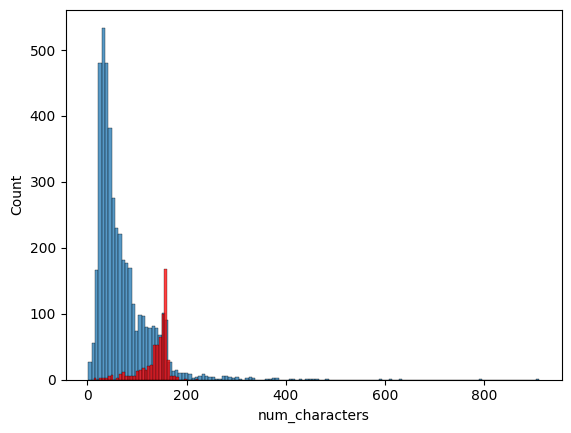

In [22]:
sns.histplot(df[df["target"]==0]['num_characters'])
sns.histplot(df[df["target"]==1]['num_characters'], color='red')

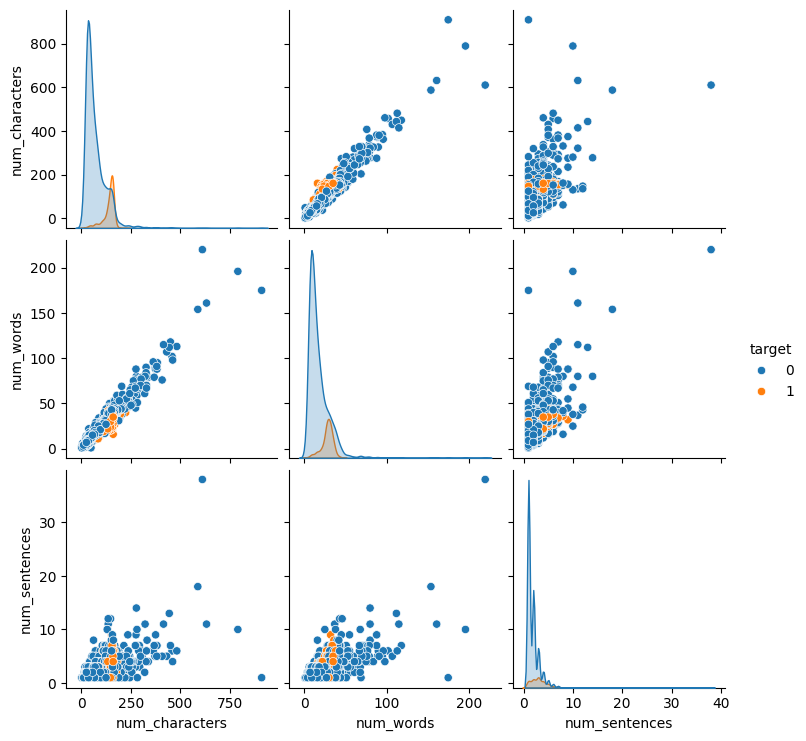

In [23]:
sns.pairplot(df, hue='target')

<Axes: >

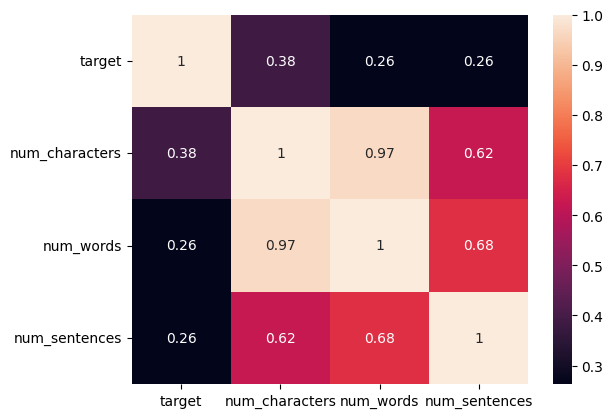

In [24]:
sns.heatmap(df.select_dtypes(include=["number"]).corr(), annot=True)

# 3. Data Preprocessing
1. lowercase
2. Tokenization
3. Removing Special Characters
4. Removing Stop words and Punctuations
5. Stemming

In [25]:
ps = PorterStemmer()
def transform_text(text):
    text = text.lower()   # lower case

    text = nltk.word_tokenize(text)   # tokenize

    y = []
    for i in text:
        if i.isalnum():
            y.append(i)    # removing special characters

    text = y.copy()
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:   # removing stop words and punctuations
            y.append(i)
            
    text = y.copy()
    y.clear()
    for i in text:               # Stemming
        y.append(ps.stem(i))
    return " ".join(y)

In [26]:
df["transformed_text"] = df["text"].apply(transform_text)

In [27]:
from collections import Counter

In [28]:
spam_corpus = (" ".join(df[df["target"]==1]["transformed_text"].values)).split()

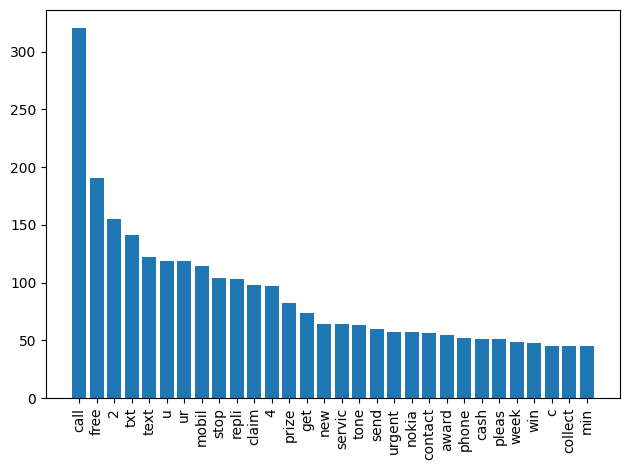

In [29]:
plt.bar(pd.DataFrame(Counter(spam_corpus).most_common(30))[0], pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.tight_layout()

In [30]:
ham_corpus = (" ".join(df[df["target"]==0]["transformed_text"].values)).split()

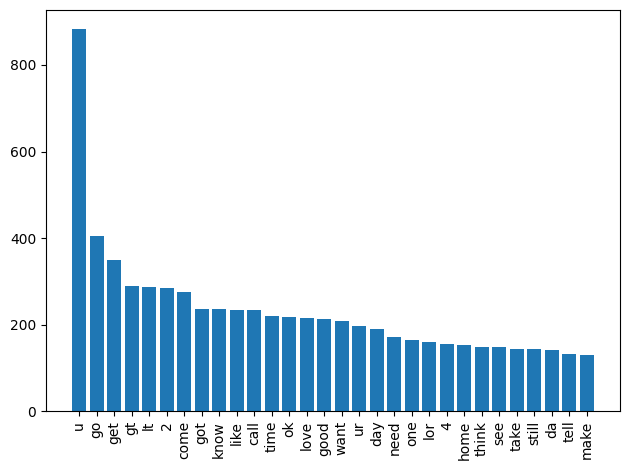

In [31]:
plt.bar(pd.DataFrame(Counter(ham_corpus).most_common(30))[0], pd.DataFrame(Counter(ham_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.tight_layout()

# 4. Model Building

In [32]:
tfidf = TfidfVectorizer(max_features=3000)

In [33]:
X = tfidf.fit_transform(df['transformed_text']).toarray()   # changing word to number using tfidf technique

In [34]:
y = df["target"].values

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [36]:
mnb = MultinomialNB()

mnb.fit(X_train, y_train)

mnb_pred = mnb.predict(X_test)

mnb_acc = accuracy_score(y_test, mnb_pred)

mnb_pre = precision_score(y_test, mnb_pred)

print(mnb_acc, mnb_pre)

0.9709864603481625 1.0


In [37]:
pickle.dump(tfidf, open("Vectorizer.pkl", "wb"))
pickle.dump(mnb, open("Model.pkl", "wb"))